<center><h1>Tree-Based Methods</h1></center>

## 1. Tree-Based Methods

Import packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, make_scorer
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict

### (a) Download the APS Failure data

In [3]:
APS_Failure_train = pd.read_csv('../Data/aps_failure_training_set.csv', skiprows=20, na_values = 'na')
APS_Failure_test = pd.read_csv('../Data/aps_failure_test_set.csv', skiprows=20, na_values = 'na')
APS_Failure_data = pd.concat([APS_Failure_train, APS_Failure_test])

In [4]:
print(APS_Failure_train.shape)
APS_Failure_train.head(2)

(60000, 171)


class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   

    ee_008  ee_009  ef_000  eg_000  
0  73224.0     0.0     0.0     0.0  
1  97576.0  1500.0     0.0     0.0  

[2 rows x 171 columns]

In [5]:
print(APS_Failure_test.shape)
APS_Failure_test.head(4)

(16000, 171)


class  aa_000  ab_000  ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg      60     0.0    20.0    12.0     0.0     0.0     0.0     0.0   
1   neg      82     0.0    68.0    40.0     0.0     0.0     0.0     0.0   
2   neg   66002     2.0   212.0   112.0     0.0     0.0     0.0     0.0   
3   neg   59816     NaN  1010.0   936.0     0.0     0.0     0.0     0.0   

   ag_002  ...    ee_002    ee_003    ee_004    ee_005     ee_006    ee_007  \
0     0.0  ...    1098.0     138.0     412.0     654.0       78.0      88.0   
1     0.0  ...    1068.0     276.0    1620.0     116.0       86.0     462.0   
2     0.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0  153680.0   
3     0.0  ...  540820.0  243270.0  483302.0  485332.0   431376.0  210074.0   

     ee_008  ee_009  ef_000  eg_000  
0       0.0     0.0     0.0     0.0  
1       0.0     0.0     0.0     0.0  
2     516.0     0.0     0.0     0.0  
3  281662.0  3232.0     0.0     0.0  

[4 rows x 171 columns]

In [6]:
print(APS_Failure_data.shape)
APS_Failure_data.head(2)

(76000, 171)


class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   

    ee_008  ee_009  ef_000  eg_000  
0  73224.0     0.0     0.0     0.0  
1  97576.0  1500.0     0.0     0.0  

[2 rows x 171 columns]

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Imputation techniques can be categorized into two main types: single and multiple. In this assignment, I will use single imputation.

There are several options for imputaion:
1. Mean imputation: calculating the average from observed data without missing values. It has the advantage of keeping the same mean and the same sample size
2. Substitution: filling in the missing value with data from a newly selected individual outside the initial sample: bringing in an external data point to replace the missing one
3. Hot deck imputation: selecting a random value from a pool of individuals within the sample who share similar characteristics.The imputed value should falls within a plausible range and a level of variability should be determined for accurate standard error estimation.
4. cold deck imputation: chooses a value from individuals with similar characteristics but lacks the random variation found in hot deck imputation, potentially selecting the same individual's value each time based on a set criterion.
5. Regression imputation: predicts missing values using a regression model based on other variables
6. Stochastic regression imputation: adding a random residual to the predicted value, combining the benefits of regression imputation with added variability, forming the basis for many multiple imputation methods.
7. Interpolation and extrapolation: estimate missing values from other observations for the same individual, typically applied to longitudinal data. 


In [7]:
# filled the missing value using mean imputation
APS_Failure_data_filled = APS_Failure_data.fillna(APS_Failure_data.mean(numeric_only=True))

In [8]:
print(APS_Failure_data_filled.shape)
APS_Failure_data_filled.head(2)

(76000, 171)


class  aa_000   ab_000        ac_000         ad_000  ae_000  af_000  ag_000  \
0   neg   76698  0.72556  2.130706e+09     280.000000     0.0     0.0     0.0   
1   neg   33058  0.72556  0.000000e+00  150629.962105     0.0     0.0     0.0   

   ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0     0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1     0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   

     ee_007   ee_008  ee_009  ef_000  eg_000  
0  157956.0  73224.0     0.0     0.0     0.0  
1   81140.0  97576.0  1500.0     0.0     0.0  

[2 rows x 171 columns]

In [9]:
APS_Failure_train_filled = APS_Failure_train.fillna(APS_Failure_train.mean(numeric_only=True))

In [10]:
print(APS_Failure_train_filled.shape)
APS_Failure_train_filled.head(2)

(60000, 171)


class  aa_000    ab_000        ac_000         ad_000  ae_000  af_000  \
0   neg   76698  0.713189  2.130706e+09     280.000000     0.0     0.0   
1   neg   33058  0.713189  0.000000e+00  190620.639314     0.0     0.0   

   ag_000  ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005  \
0     0.0     0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0   
1     0.0     0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0   

     ee_006    ee_007   ee_008  ee_009  ef_000  eg_000  
0  339156.0  157956.0  73224.0     0.0     0.0     0.0  
1  133654.0   81140.0  97576.0  1500.0     0.0     0.0  

[2 rows x 171 columns]

In [11]:
APS_Failure_test_filled = APS_Failure_test.fillna(APS_Failure_test.mean(numeric_only=True))

In [12]:
print(APS_Failure_test_filled.shape)
APS_Failure_test_filled.head(4)

(16000, 171)


class  aa_000    ab_000  ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg      60  0.000000    20.0    12.0     0.0     0.0     0.0     0.0   
1   neg      82  0.000000    68.0    40.0     0.0     0.0     0.0     0.0   
2   neg   66002  2.000000   212.0   112.0     0.0     0.0     0.0     0.0   
3   neg   59816  0.772065  1010.0   936.0     0.0     0.0     0.0     0.0   

   ag_002  ...    ee_002    ee_003    ee_004    ee_005     ee_006    ee_007  \
0     0.0  ...    1098.0     138.0     412.0     654.0       78.0      88.0   
1     0.0  ...    1068.0     276.0    1620.0     116.0       86.0     462.0   
2     0.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0  153680.0   
3     0.0  ...  540820.0  243270.0  483302.0  485332.0   431376.0  210074.0   

     ee_008  ee_009  ef_000  eg_000  
0       0.0     0.0     0.0     0.0  
1       0.0     0.0     0.0     0.0  
2     516.0     0.0     0.0     0.0  
3  281662.0  3232.0     0.0     0.0  

[4 rows x 171 columns]

#### (ii) Calculate the coefficient of variation

In [13]:
APS_Failure_data_means = APS_Failure_data_filled.mean(numeric_only=True)
APS_Failure_data_SD = APS_Failure_data_filled.std(numeric_only=True)
APS_Failure_data_cv = APS_Failure_data_SD / APS_Failure_data_means
pd.set_option('display.max_rows', None)
APS_Failure_data_cv

aa_000      4.328608
ab_000      2.178273
ac_000      2.167653
ad_000    206.721500
ae_000     22.293670
af_000     18.209016
ag_000     91.460654
ag_001     42.084343
ag_002     17.625909
ag_003      8.753300
ag_004      5.475116
ag_005      2.964230
ag_006      2.352588
ag_007      2.812498
ag_008      6.274980
ag_009     32.167057
ah_000      2.315540
ai_000     18.506308
aj_000     43.144480
ak_000     78.622988
al_000      9.111991
am_0        9.067195
an_000      2.254227
ao_000      2.276114
ap_000      3.085885
aq_000      2.853471
ar_000     10.569202
as_000    113.882755
at_000     23.187060
au_000     86.085638
av_000      5.730485
ax_000      3.859035
ay_000     40.902519
ay_001     49.248635
ay_002     38.342319
ay_003     28.330036
ay_004     33.040132
ay_005     12.009061
ay_006      3.021921
ay_007      3.249895
ay_008      3.943781
ay_009     77.461101
az_000      9.019870
az_001      7.374967
az_002     12.050428
az_003      7.565569
az_004      2.837815
az_005      3

#### (iii) Plot a correlation matrix

In [14]:
# Calculate the correlation matrix
APS_Failure_data_corr_matrix = APS_Failure_data_filled.corr(numeric_only=True)
APS_Failure_data_corr_matrix.style.background_gradient()
# # Plot the correlation matrix
# plt.figure(figsize=(15, 15))
# sns.heatmap(APS_Failure_data_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
# plt.title('Correlation Matrix of Features')
# plt.show()

/Users/elinorzhang/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/elinorzhang/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


The column 'cd_000' is constant and hence its correlation with other columns cannot be computed. To deal with this issue, we remove this columm and calculate the matrix again.

In [15]:
# Calculate the correlation matrix
APS_Failure_data_corr_matrix = APS_Failure_data_filled.corr(numeric_only=True)
APS_Failure_data_cleaned_corr_matrix = APS_Failure_data_corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

APS_Failure_data_cleaned_corr_matrix = APS_Failure_data_cleaned_corr_matrix.fillna(0)
APS_Failure_data_cleaned_corr_matrix = APS_Failure_data_cleaned_corr_matrix.style.background_gradient()
APS_Failure_data_cleaned_corr_matrix

#### (iv) Make scatter plots and box plots

In [16]:
# Select the top |sqrt(170)| features with the highest CV
num_features = int(np.sqrt(170))
top_features = APS_Failure_data_cv.nlargest(num_features).index.tolist()

# Create a new DataFrame with only the top CV features
# APS_Failure_data_top_cv = APS_Failure_data_filled[top_features]
APS_Failure_data_top_cv = APS_Failure_data_filled[top_features + ['class']]

In [17]:
print(APS_Failure_data_top_cv.columns)
print(APS_Failure_data_top_cv.shape)
APS_Failure_data_top_cv.head()

Index(['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'as_000', 'dh_000',
       'df_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009', 'class'],
      dtype='object')
(76000, 14)


cf_000         co_000         ad_000  cs_009  dj_000  as_000  \
0       2.000000     220.000000     280.000000     0.0     0.0     0.0   
1  150231.156793  150517.375485  150629.962105     0.0     0.0     0.0   
2       0.000000       0.000000     100.000000     0.0     0.0     0.0   
3       2.000000       2.000000      66.000000     0.0     0.0     0.0   
4       0.000000     202.000000     458.000000     0.0     0.0     0.0   

   dh_000  df_000  ag_000  au_000  ak_000  az_009  ay_009 class  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   neg  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0   neg  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0   neg  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0   neg  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0   neg

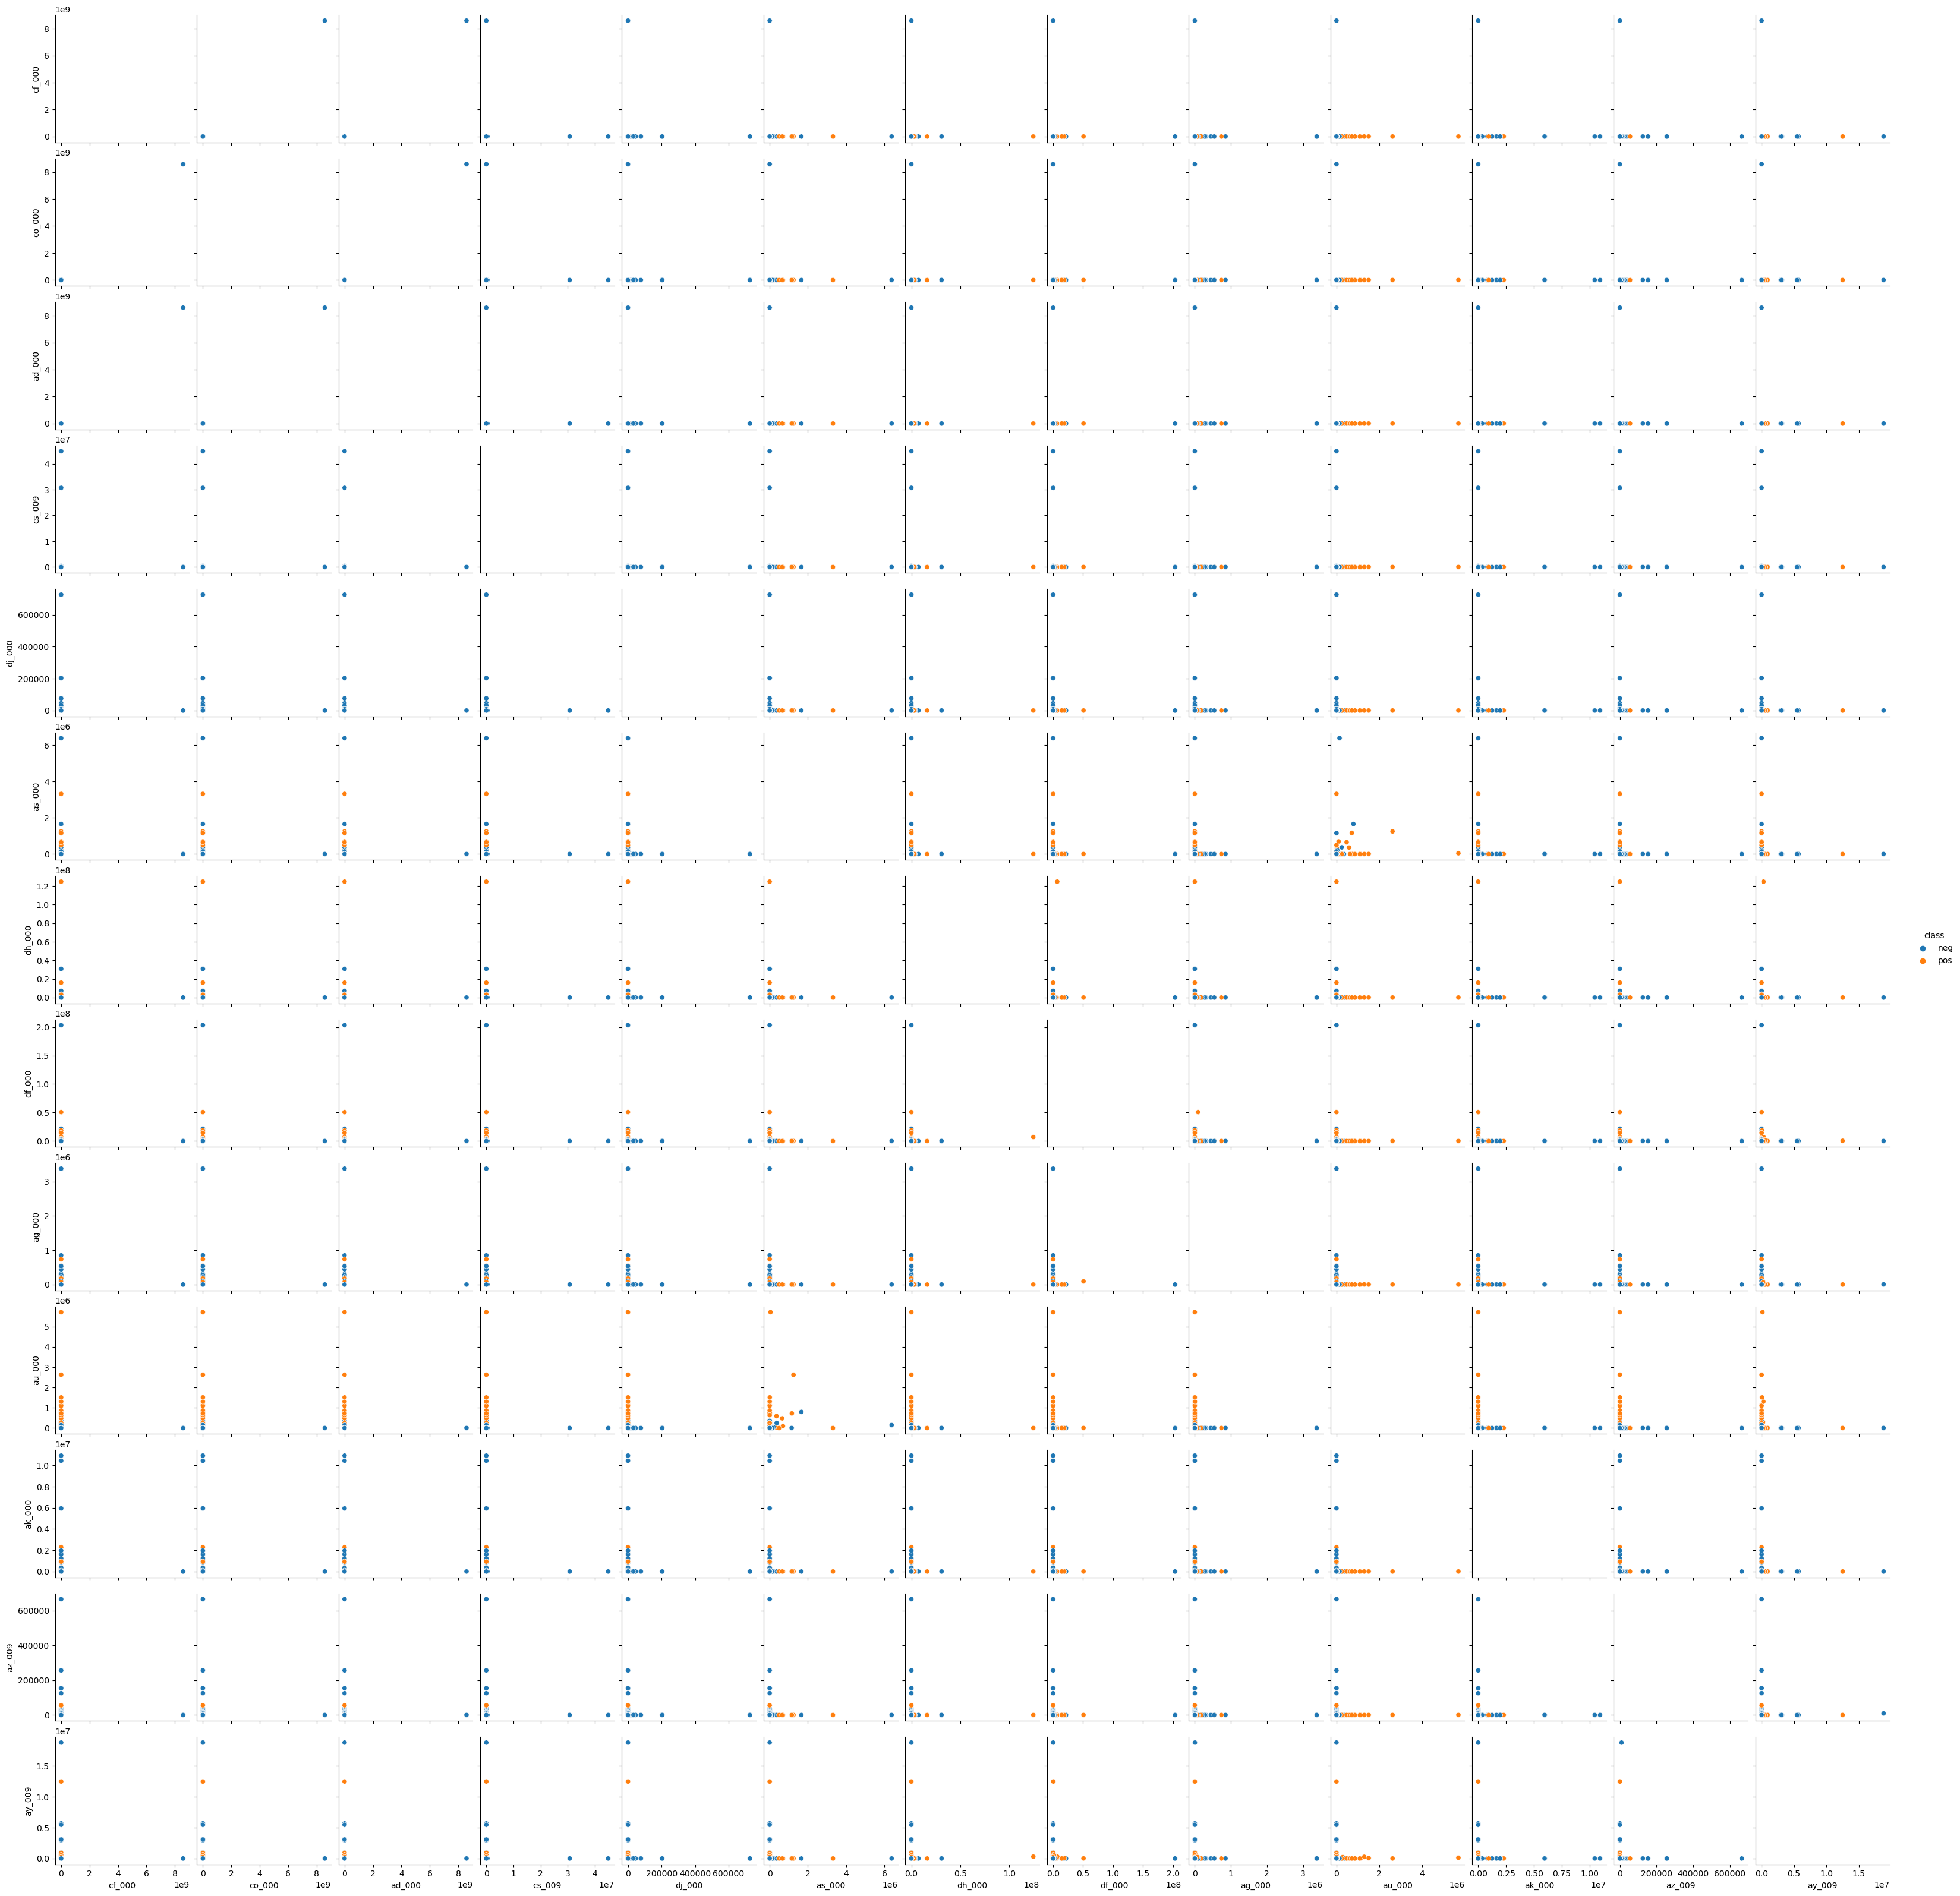

In [19]:
# Pairwise scatter plots of the top CV features
sns.pairplot(APS_Failure_data_top_cv, hue='class',diag_kind='none')
plt.show()

It is hard to draw conclusion based on the scatterplot. 

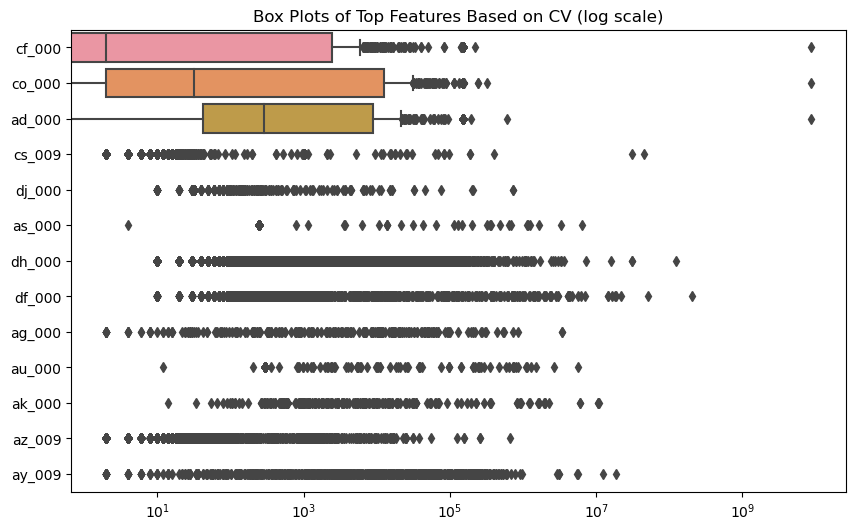

In [18]:
# Box plots for each of the top CV features (log scale: to observe the distribution)
if 'class' in top_features:
    top_features.remove('class')
    
fig, axes = plt.subplots(figsize=(10, 6))
box = sns.boxplot(data=APS_Failure_data_top_cv, orient='h', ax=axes)
box.set(xscale="log")
plt.title('Box Plots of Top Features Based on CV (log scale)')
plt.show()

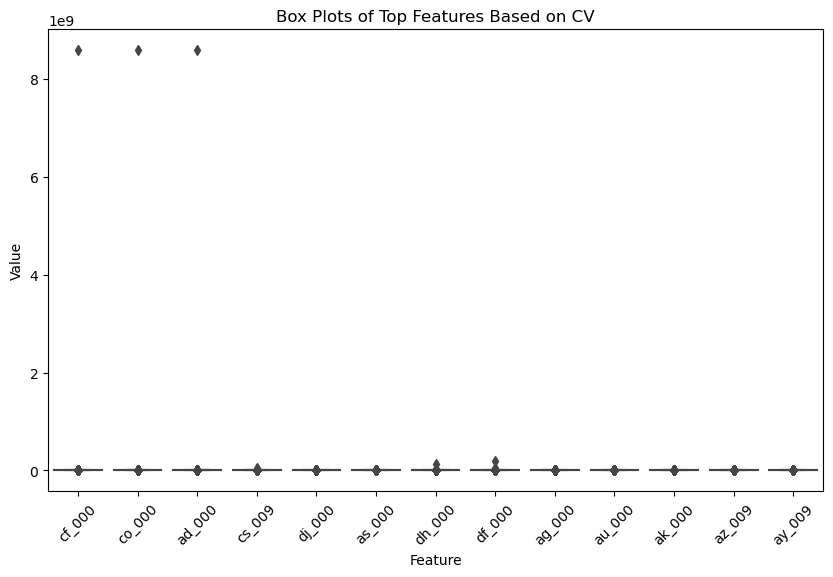

In [19]:
# Box plots for each of the top CV features
if 'class' in top_features:
    top_features.remove('class')

melted_data = APS_Failure_data_top_cv.melt(value_vars=top_features, var_name='Feature', value_name='Value')
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='Feature', y='Value', data=melted_data)
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.title('Box Plots of Top Features Based on CV')
plt.show()


#### (v) Is this data set imbalanced?

In [20]:
# Assuming 'class' is the name of your target variable column in APS_Failure_data_filled
class_train_cnt = APS_Failure_train_filled['class'].value_counts()
class_test_cnt = APS_Failure_test_filled['class'].value_counts()
# Assessing the balance
total_train = class_train_cnt.sum()
total_test = class_test_cnt.sum()
print(f"Total training data: {total_train}")
print(class_train_cnt)
print(f"Total testing data: {total_test}")
print(class_test_cnt)

Total training data: 60000
neg    59000
pos     1000
Name: class, dtype: int64
Total testing data: 16000
neg    15625
pos      375
Name: class, dtype: int64


Based on the results, the datasets for both training and testing are imbalanced.

### (c) Train a random forest

In [21]:
# split the data
train_features = APS_Failure_train_filled.drop('class', axis=1)
train_targets = APS_Failure_train_filled['class']

test_features = APS_Failure_test_filled.drop('class', axis=1)
test_targets = APS_Failure_test_filled['class']

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=5, random_state=42, oob_score=True)
rf_classifier.fit(train_features, train_targets)

RandomForestClassifier(max_depth=5, oob_score=True, random_state=42)

In [22]:
def evaluate_performance(actual, predictions, probabilities, title):
    # Confusion Matrix and Accuracy
    print(f"Confusion Matrix for {title}:")
    print(confusion_matrix(actual, predictions))
    accuracy = accuracy_score(actual, predictions)
    print(f"Accuracy for {title}: {accuracy:.4f}")

    # Calculate and plot the ROC Curve and AUC
    fpr, tpr, _ = roc_curve(actual, probabilities[:, 1], pos_label='pos')  # adjust pos_label as necessary
    auc_score = roc_auc_score(actual, probabilities[:, 1])
    plt.plot(fpr, tpr, label=f'{title} set ROC (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

Confusion Matrix for Training:
[[58976    24]
 [  432   568]]
Accuracy for Training: 0.9924


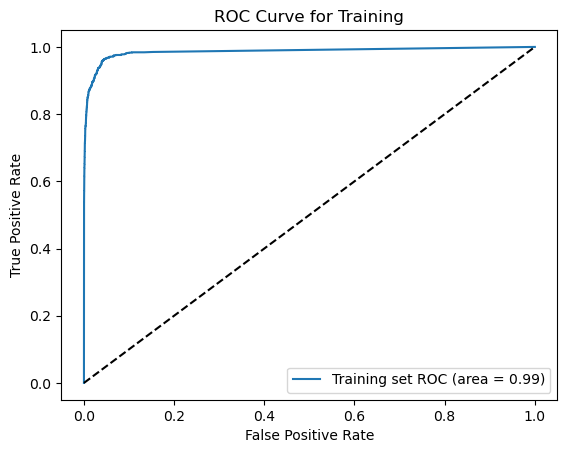

Confusion Matrix for Testing:
[[15612    13]
 [  172   203]]
Accuracy for Testing: 0.9884


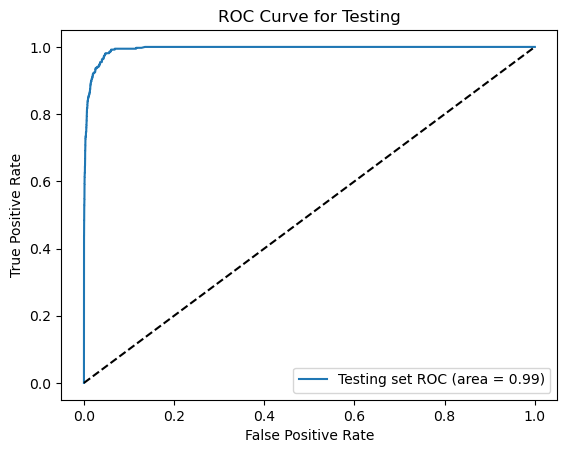

In [23]:
# Evaluate Training set
train_preds = rf_classifier.predict(train_features)
train_probs = rf_classifier.predict_proba(train_features)
evaluate_performance(train_targets, train_preds, train_probs, 'Training')

# Evaluate Test set
test_preds = rf_classifier.predict(test_features)
test_probs = rf_classifier.predict_proba(test_features)
evaluate_performance(test_targets, test_preds, test_probs, 'Testing')

In [24]:
# OOB Error Estimate
oob_error_estimate = 1 - rf_classifier.oob_score_
print(f"OOB Error Estimate: {oob_error_estimate:.4f}")

# Test Error
test_accuracy = accuracy_score(test_targets, test_preds)
test_error_estimate = 1 - test_accuracy
print(f"Test Error Estimate: {test_error_estimate:.4f}")

OOB Error Estimate: 0.0093
Test Error Estimate: 0.0116


### (d) Research class imbalance in random forest

In [25]:
# compensate for class imbalance
rf_classifier_balanced = RandomForestClassifier(max_depth=5, 
                                                random_state=42, 
                                                oob_score=True, 
                                                class_weight='balanced') # Using class_weight='balanced'

# Train with balanced class weights
rf_classifier_balanced.fit(train_features, train_targets)

RandomForestClassifier(class_weight='balanced', max_depth=5, oob_score=True,
                       random_state=42)

In [26]:
def evaluate_performance(actual, predictions, probabilities, title):
    # Confusion Matrix and Accuracy
    print(f"Confusion Matrix for {title}:")
    print(confusion_matrix(actual, predictions))
    accuracy = accuracy_score(actual, predictions)
    print(f"Accuracy for {title}: {accuracy:.4f}")

    # Calculate and plot the ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(actual, probabilities[:, 1], pos_label='pos')  # Adjust pos_label as necessary
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

Confusion Matrix for Training:
[[56610  2390]
 [   31   969]]
Accuracy for Training: 0.9597


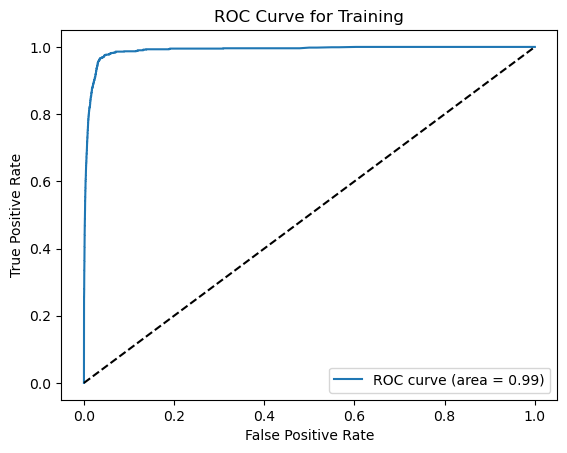

Confusion Matrix for Testing:
[[15014   611]
 [   12   363]]
Accuracy for Testing: 0.9611


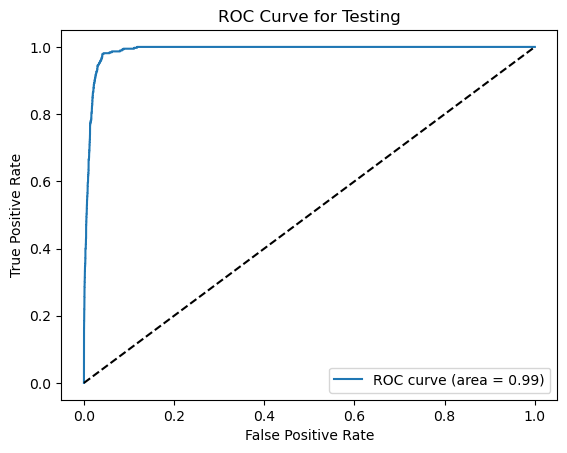

In [27]:
# Evaluate the Training set with balanced class weights
train_preds_balanced = rf_classifier_balanced.predict(train_features)
train_probs_balanced = rf_classifier_balanced.predict_proba(train_features)
evaluate_performance(train_targets, train_preds_balanced, train_probs_balanced, 'Training')

# Evaluate the Test set with balanced class weights
test_preds_balanced = rf_classifier_balanced.predict(test_features)
test_probs_balanced = rf_classifier_balanced.predict_proba(test_features)
evaluate_performance(test_targets, test_preds_balanced, test_probs_balanced, 'Testing')

In [28]:
# OOB Error Estimate for the balanced model
oob_error_estimate_balanced = 1 - rf_classifier_balanced.oob_score_
print(f"OOB Error Estimate (Balanced Model): {oob_error_estimate_balanced:.4f}")

# Test Error for the balanced model
test_accuracy_balanced = accuracy_score(test_targets, test_preds_balanced)
test_error_estimate_balanced = 1 - test_accuracy_balanced
print(f"Test Error Estimate (Balanced Model): {test_error_estimate_balanced:.4f}")

OOB Error Estimate (Balanced Model): 0.0416
Test Error Estimate (Balanced Model): 0.0389


##### Model comparison

In [29]:
oob_error_initial = oob_error_estimate
test_error_initial = test_error_estimate
accuracy_training_initial = accuracy_score(train_targets, train_preds) 
auc_training_initial = roc_auc_score(train_targets, train_probs[:, 1]) 
accuracy_testing_initial = accuracy_score(test_targets, test_preds)
auc_testing_initial = roc_auc_score(test_targets, test_probs[:, 1])

oob_error_balanced = oob_error_estimate_balanced
test_error_balanced = test_error_estimate_balanced
accuracy_training_balanced = accuracy_score(train_targets, train_preds_balanced)
auc_training_balanced = roc_auc_score(train_targets, train_probs_balanced[:, 1])
accuracy_testing_balanced = accuracy_score(test_targets, test_preds_balanced)
auc_testing_balanced = roc_auc_score(test_targets, test_probs_balanced[:, 1])

metrics_data = {
    "Metric": [
        "OOB Error Estimate",
        "Test Error Estimate",
        "Accuracy (Training)",
        "AUC (Training)",
        "Accuracy (Testing)",
        "AUC (Testing)"
    ],
    "Initial Model": [
        oob_error_initial,
        test_error_initial,
        accuracy_training_initial,
        auc_training_initial,
        accuracy_testing_initial,
        auc_testing_initial
    ],
    "Balanced Model": [
        oob_error_balanced,
        test_error_balanced,
        accuracy_training_balanced,
        auc_training_balanced,
        accuracy_testing_balanced,
        auc_testing_balanced
    ]
}

metrics_comparison = pd.DataFrame(metrics_data)
print(metrics_comparison)

                Metric  Initial Model  Balanced Model
0   OOB Error Estimate       0.009283        0.041567
1  Test Error Estimate       0.011563        0.038937
2  Accuracy (Training)       0.992400        0.959650
3       AUC (Training)       0.986241        0.989966
4   Accuracy (Testing)       0.988437        0.961063
5        AUC (Testing)       0.994101        0.989789


Based on the result, the initial model demonstrates higher accuracy and lower error rates both in training and testing, suggesting a potentially better fit to the majority class. The balanced model achieves notably higher AUC scores, meaning the balanced model, offers a more robust performance in distinguishing between classes. The increase in OOB and test error estimates for the balanced model suggests a trade-off for enhanced generalizability and fairness, particularly in better identifying the minority class, which is often the more critical aspect in imbalanced datasets.

### (e) XGBoost and Model Trees

In [30]:
from sklearn.model_selection import RandomizedSearchCV

In [31]:
X_train = APS_Failure_train_filled.drop('class', axis=1)
y_train = APS_Failure_train_filled['class'].map({'pos': 1, 'neg': 0})

X_test = APS_Failure_test_filled.drop('class', axis=1)
y_test = APS_Failure_test_filled['class'].map({'pos': 1, 'neg': 0})

In [38]:
params = {'alpha': np.arange(0.1, 1.1, 0.1)}
# Initialize and train the XGBoost Classifier
rf_classifier = xgb.XGBClassifier(max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=sum(y_train==0)/sum(y_train==1))
clf = RandomizedSearchCV(estimator=rf_classifier,
                         param_distributions=params,
                         n_iter = 10,
                         scoring='accuracy')
clf.fit(X_train, y_train)
best_param = clf.best_params_
best_param

{'alpha': 0.6}

We use a random grid search and cross validation to find the best value of alpha (the penalization parameter for the l1 norm penalty), and then fit xgboost with the optimal alpha.

In [39]:
rf_classifier = xgb.XGBClassifier(max_depth=5, random_state=42, alpha = 0.6, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=sum(y_train==0)/sum(y_train==1))
rf_classifier.fit(X_train, y_train)

XGBClassifier(alpha=0.6, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [40]:
# evaluate model performance
def evaluate_performance(model, X, y, title):
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]

    # Confusion Matrix and Accuracy
    conf_mat = confusion_matrix(y, predictions)
    print(f"Confusion Matrix for {title}:")
    print(conf_mat)

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

    print(f"AUC for {title}: {roc_auc:.4f}")

Confusion Matrix for Training:
[[58987    13]
 [    0  1000]]


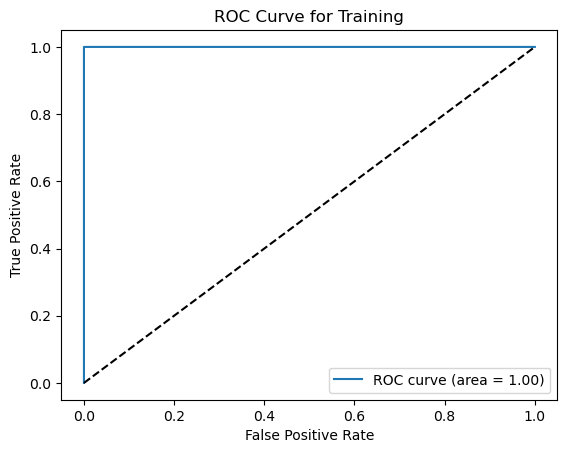

AUC for Training: 1.0000
Confusion Matrix for Testing:
[[15553    72]
 [   58   317]]


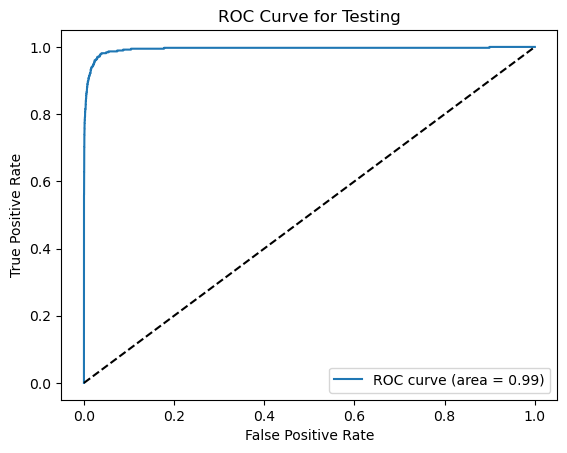

AUC for Testing: 0.9938


Cross-validation: 100%|███████████████████████████| 5/5 [00:16<00:00,  3.26s/it]

Cross-validation AUC Scores: [0.9863886802463175, 0.9918607611173051, 0.9758562394449093, 0.9927769273792352, 0.9929540222660269]
Mean CV AUC Score: 0.9879673260907588
Test AUC Score: 0.9937500159999999


In [41]:
# Evaluate performance on Training and Test sets
evaluate_performance(rf_classifier, X_train, y_train, "Training")
evaluate_performance(rf_classifier, X_test, y_test, "Testing")

# Cross-validation 
cv_strategy = KFold(n_splits=5)

cv_scores = []
for train_idx, test_idx in tqdm(cv_strategy.split(X_train), total=cv_strategy.get_n_splits(), desc='Cross-validation'):
    X_cv_train, X_cv_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_cv_train, y_cv_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    model = xgb.XGBClassifier(max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=sum(y_cv_train==0)/sum(y_cv_train==1))
    model.fit(X_cv_train, y_cv_train)
    cv_scores.append(roc_auc_score(y_cv_test, model.predict_proba(X_cv_test)[:, 1]))

print("Cross-validation AUC Scores:", cv_scores)
print("Mean CV AUC Score:", np.mean(cv_scores))

# Test AUC
test_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print("Test AUC Score:", test_auc)

### (f) Use SMOTE to pre-process your data

To guarantee the comparison is fair, we use the same training and test set from the last section. On the training set, we first apply smote to preprocess the data, and then apply the same grid search with cross validation to find the best alpha for xgboost.

In [43]:
# Apply SMOTE to address class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

params = {'alpha': np.arange(0.1, 2.1, 0.1)}
rf_classifier = xgb.XGBClassifier(max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=sum(y_train==0)/sum(y_train==1))
clf = RandomizedSearchCV(estimator=rf_classifier,
                         param_distributions=params,
                         n_iter = 10,
                         scoring='accuracy')
clf.fit(X_train_smote, y_train_smote)
best_param = clf.best_params_
best_param

{'alpha': 1.1}

The best alhha after the preprocess step of smote is now 1.1, which is different from the one in the last section.

In [44]:
# Train the XGBoost Model with L1 regularization
model_smote = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='logloss',
                                use_label_encoder=False, alpha=1.1,  # Adjust reg_alpha for L1 regularization
                                max_depth=5, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

XGBClassifier(alpha=1.1, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [45]:
# Function to evaluate model performance
def evaluate_performance(model, X, y, title):
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]
    conf_mat = confusion_matrix(y, predictions)
    auc_score = roc_auc_score(y, probabilities)
    
    print(f"Confusion Matrix for {title}:")
    print(conf_mat)
    print(f"AUC for {title}: {auc_score:.4f}")
    
    fpr, tpr, _ = roc_curve(y, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()


Confusion Matrix for Training SMOTE:
[[58999     1]
 [    8   992]]
AUC for Training SMOTE: 1.0000


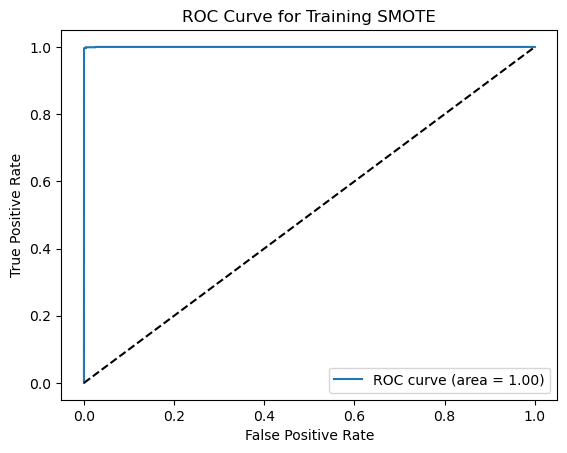

Confusion Matrix for Testing SMOTE:
[[15358   267]
 [   47   328]]
AUC for Testing SMOTE: 0.9892


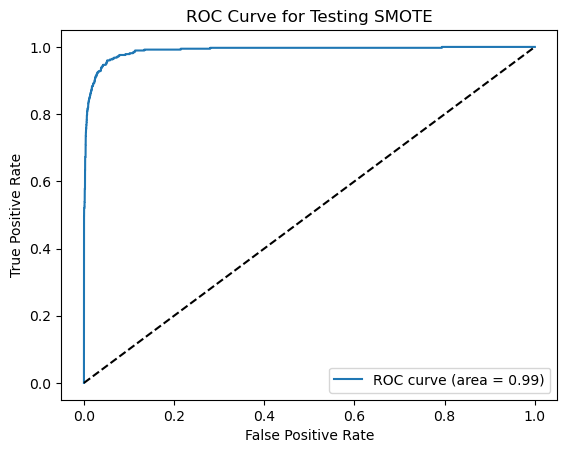

Cross-validation: 100%|███████████████████████████| 5/5 [00:35<00:00,  7.04s/it]

Mean AUC Score with SMOTE: 0.9884570853873695


In [46]:
# Evaluate on the training and testing sets
evaluate_performance(model_smote, X_train, y_train, "Training SMOTE")
evaluate_performance(model_smote, X_test, y_test, "Testing SMOTE")

# Cross-Validation with progress bar
kf = KFold(n_splits=5)
auc_scores_smote = []

# Adding a progress bar to the cross-validation process
for train_index, val_index in tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Cross-validation'):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Apply SMOTE within the CV loop
    X_fold_train_smote, y_fold_train_smote = smote.fit_resample(X_fold_train, y_fold_train)
    
    # Train the model on the SMOTE-augmented training fold
    model_fold = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='logloss',
                                   use_label_encoder=False, reg_alpha=1,  # L1 regularization
                                   max_depth=5, random_state=42)
    model_fold.fit(X_fold_train_smote, y_fold_train_smote)
    
    # Evaluate on the validation fold
    y_fold_val_pred_proba = model_fold.predict_proba(X_fold_val)[:, 1]
    auc_score = roc_auc_score(y_fold_val, y_fold_val_pred_proba)
    auc_scores_smote.append(auc_score)

print("Mean AUC Score with SMOTE:", np.mean(auc_scores_smote))

SMOTE is a good method to deal with imbalanced data, but for this question, the average AUC with and without SMOTE are very similar.

## Reference

* [Seven ways to make up data: common methods to imputing missing data](https://www.theanalysisfactor.com/seven-ways-to-make-up-data-common-methods-to-imputing-missing-data/#:~:text=There%20are%20two%20types%20of%20imputation%E2%80%93single%20or%20multiple.)
* [A comparison of 6 data imputation methods with AI-powered synthetic data imputation](https://mostly.ai/blog/smart-imputation-with-synthetic-data#:~:text=Mean%2FMedian%2FMode%20imputation%20is,missing%20numbers%20using%20statistical%20averages.)
* [diag_kind='none'](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
* [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)
* [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html)
* [tqdm](https://pypi.org/project/tqdm/)
* [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)